## ch04
- https://github.com/thampiman/interpretable-ai-book/blob/master/Chapter_04/chapter_04.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.10.05</div>
<div style="text-align: right"> Last update: 2023.10.05</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import math
import numpy as np
np.random.seed(24)
import pandas as pd
from tqdm import tqdm

from sympy import *
import operator
from IPython.core.display import display

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler

import torch
torch.manual_seed(24)
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")

## Diagnostics+ AI: Breast cancer diagnosis

- 1장과 2장에서 소개한 진단+로 돌아가 보겠습니다.  
- 이 센터는 유방암 진단에 AI 기능을 확장하고자 약 570명의 환자로부터 유방 종괴를 세침흡인한 이미지를 디지털화했습니다.  
- 이렇게 디지털화된 이미지에서 이미지에 존재하는 세포핵의 특성을 설명하는 특징을 계산했습니다.  
- 각 세포핵에 대해 다음 10가지 특징을 사용하여 특성을 설명합니다:  
    - Radius
    - Texture
    - Perimeter
    - Area
    - Smoothness
    - Compactness
    - Concavity
    - Concave points
    - Symmetry
    - Fractal dimension

환자의 이미지에 존재하는 모든 핵에 대해 이 10가지 특징 각각에 대해 평균, 표준 오차, 최대 또는 최소값이 계산됩니다.  
따라서 각 환자는 총 30개의 특징을 갖게 됩니다.  
이러한 입력 특징이 주어지면 AI 시스템의 목표는 세포가 양성인지 악성인지 예측하고 의사가 진단에 도움을 줄 수 있는 신뢰 점수를 제공하는 것입니다.  
이는 그림 4.1에 요약되어 있습니다.

![Alt text](image.png)

이 정보가 주어지면 이 문제를 머신 러닝 문제로 어떻게 공식화할 수 있을까요?  
모델의 목표는 주어진 유방 종괴가 양성인지 악성인지 예측하는 것이므로, 이 문제를 이진 분류 문제로 공식화할 수 있습니다.

### Load and Prepare data

In [3]:
data = load_breast_cancer()

In [4]:
X = data['data']
y = data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=24)
X_train = Variable(torch.from_numpy(X_train))
X_val = Variable(torch.from_numpy(X_val))
y_train = Variable(torch.from_numpy(y_train))
y_val = Variable(torch.from_numpy(y_val))
X_test = Variable(torch.from_numpy(X_test))
y_test = Variable(torch.from_numpy(y_test))

In [5]:
X[:5]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [6]:
X.shape

(569, 30)

In [7]:
X_train.shape

torch.Size([398, 30])

In [8]:
X_test.shape

torch.Size([86, 30])

In [9]:
df_data = pd.DataFrame(X, columns=data['feature_names'])
df_data['target'] = y
df_benign = df_data[df_data['target'] == 1].reset_index(drop=True)
df_malignant = df_data[df_data['target'] == 0].reset_index(drop=True)

In [10]:
df_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [11]:

df_train = pd.DataFrame(X_train, columns=data['feature_names'])
df_train['target'] = y_train
df_val = pd.DataFrame(X_val, columns=data['feature_names'])
df_val['target'] = y_val
df_test = pd.DataFrame(X_test, columns=data['feature_names'])
df_test['target'] = y_test

### EDA

Text(0, 0.5, '% of Cases')

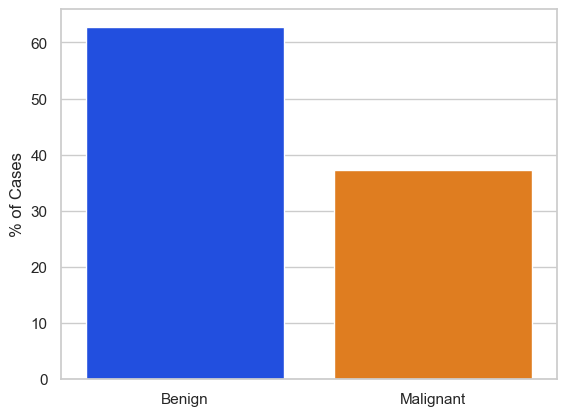

In [12]:
class_names = ['Benign', 'Malignant']
class_pc = [62.8, 37.3]
f, ax = plt.subplots()
sns.barplot(x=class_names, y=class_pc, ax=ax)
ax.set_ylabel('% of Cases')

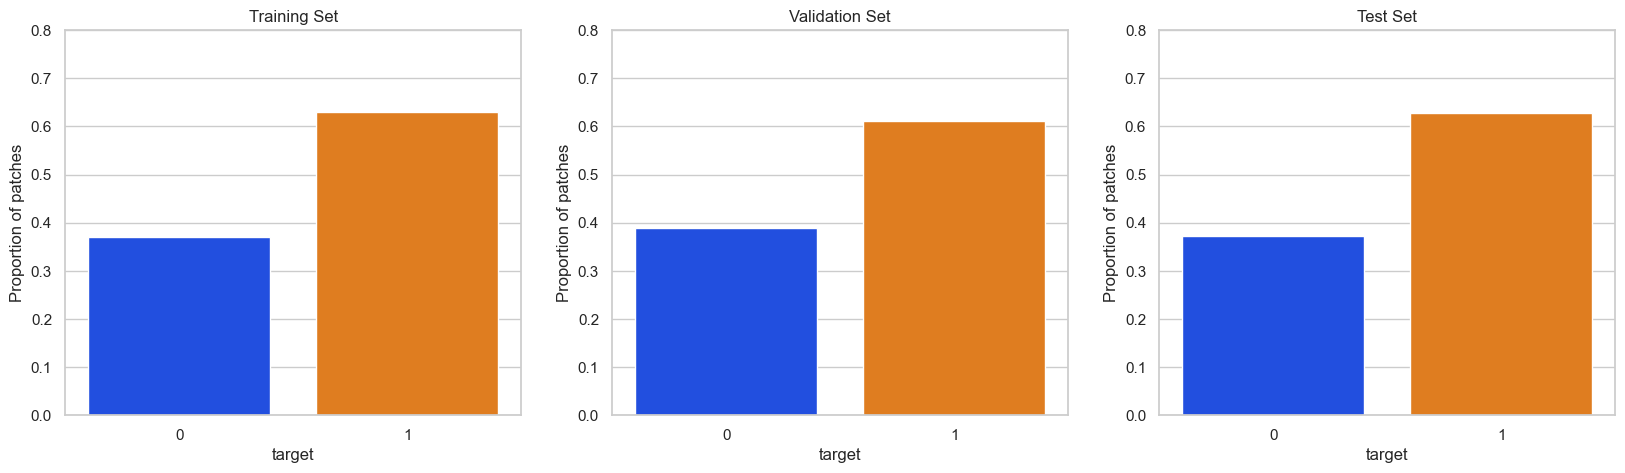

In [13]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))
df_train['target'].\
    value_counts(normalize=True).\
    rename('pc').reset_index().\
    rename(columns={'index': 'target'}).\
    pipe((sns.barplot, "data"), x='target', y='pc', ax=ax[0])
df_val['target'].\
    value_counts(normalize=True).\
    rename('pc').reset_index().\
    rename(columns={'index': 'target'}).\
    pipe((sns.barplot, "data"), x='target', y='pc', ax=ax[1])
df_test['target'].\
    value_counts(normalize=True).\
    rename('pc').reset_index().\
    rename(columns={'index': 'target'}).\
    pipe((sns.barplot, "data"), x='target', y='pc', ax=ax[2])
ax[0].set_ylabel('Proportion of patches')
ax[1].set_ylabel('Proportion of patches')
ax[2].set_ylabel('Proportion of patches')
ax[0].set_ylim([0, 0.8])
ax[1].set_ylim([0, 0.8])
ax[2].set_ylim([0, 0.8])
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
ax[2].set_title('Test Set');

Text(0.5, 1.0, 'Worst Cell Area Distribution')

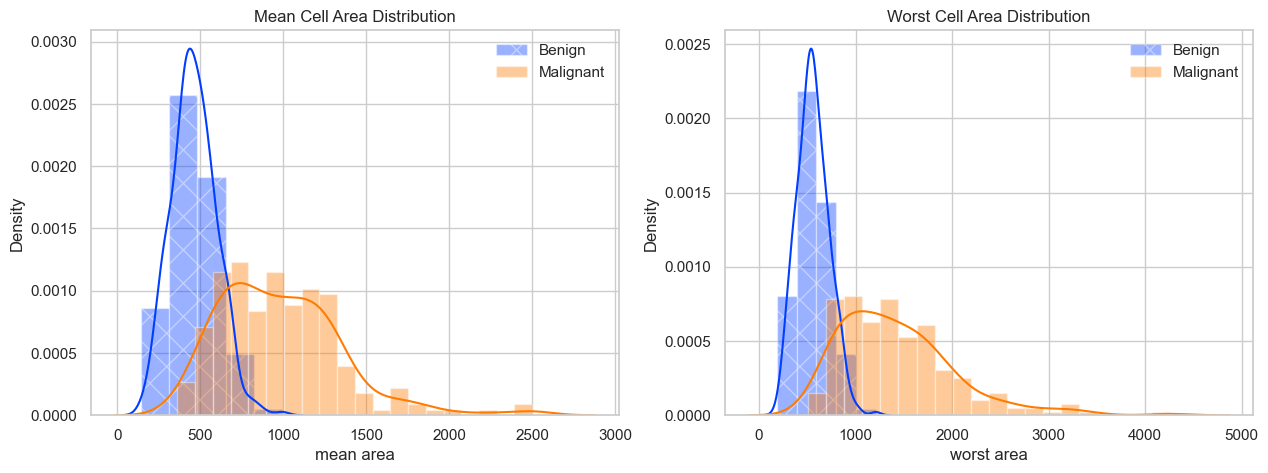

In [14]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df_benign['mean area'], 
             bins=5, 
             ax=ax[0], 
             label='Benign',
             hist_kws={"hatch": "x"})
sns.distplot(df_malignant['mean area'], bins=20, ax=ax[0], label='Malignant')
ax[0].legend()
sns.distplot(df_benign['worst area'], bins=5, ax=ax[1], label='Benign',
             hist_kws={"hatch": "x"})
sns.distplot(df_malignant['worst area'], bins=20, ax=ax[1], label='Malignant')
ax[1].legend()
ax[0].set_title('Mean Cell Area Distribution')
ax[1].set_title('Worst Cell Area Distribution')

Text(0.5, 1.0, 'Worst Cell Radius Distribution')

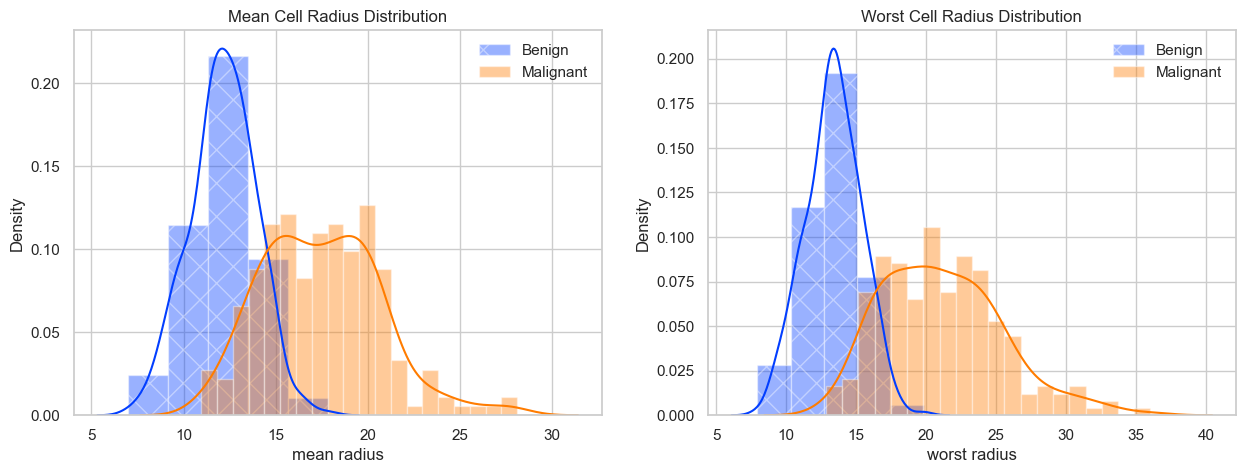

In [15]:

f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df_benign['mean radius'], bins=5, ax=ax[0], label='Benign',
             hist_kws={"hatch": "x"})
sns.distplot(df_malignant['mean radius'], bins=20, ax=ax[0], label='Malignant')
sns.distplot(df_benign['worst radius'], bins=5, ax=ax[1], label='Benign',
             hist_kws={"hatch": "x"})
sns.distplot(df_malignant['worst radius'], bins=20, ax=ax[1], label='Malignant')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Mean Cell Radius Distribution')
ax[1].set_title('Worst Cell Radius Distribution')

Text(0.5, 1.0, 'Worst Cell Perimeter Distribution')

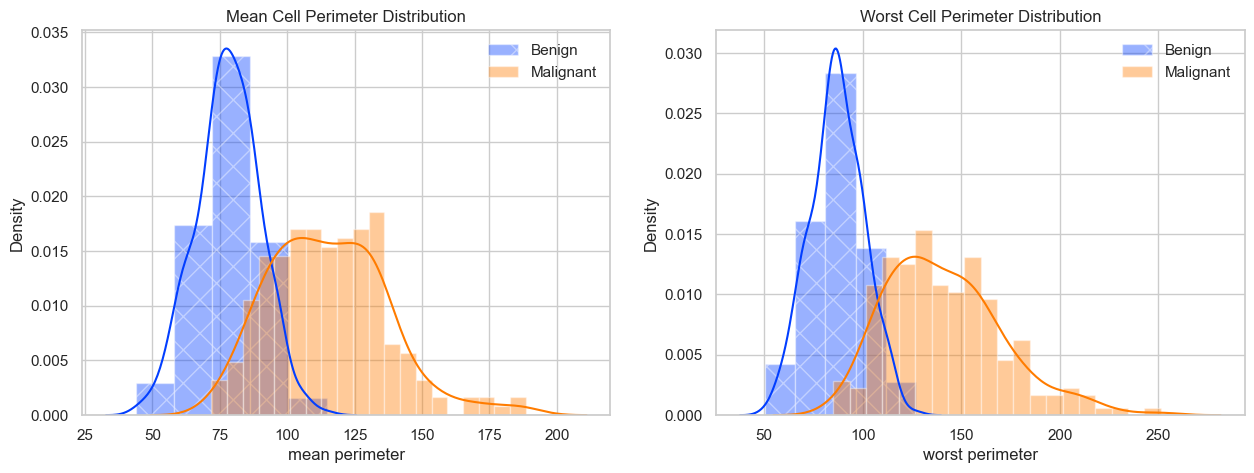

In [16]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(df_benign['mean perimeter'], bins=5, ax=ax[0], label='Benign',
             hist_kws={"hatch": "x"})
sns.distplot(df_malignant['mean perimeter'], bins=20, ax=ax[0], label='Malignant')
sns.distplot(df_benign['worst perimeter'], bins=5, ax=ax[1], label='Benign',
             hist_kws={"hatch": "x"})
sns.distplot(df_malignant['worst perimeter'], bins=20, ax=ax[1], label='Malignant')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Mean Cell Perimeter Distribution')
ax[1].set_title('Worst Cell Perimeter Distribution')

In [17]:
corr = df_data.corr()

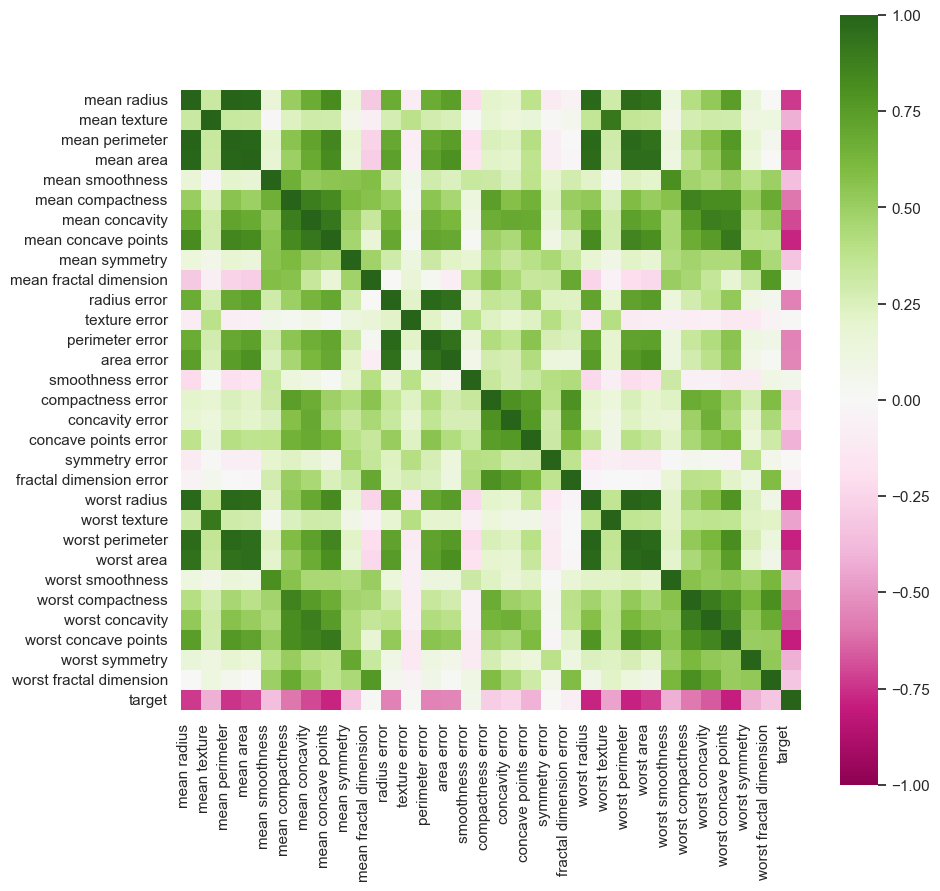

In [18]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="PiYG",
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

위 그림에서 타겟과 상관관계를 확인하는 마지막 열을 우선 보자.  
평균 셀 면적, 반지름, 둘레와 같은 특징이 대상 클래스와 높은 상관 관계가 있음을 알 수 있습니다.  
그러나 상관 계수는 음수이며, 이는 특징의 값이 클수록 대상 변수의 값이 작아진다는 것을 의미합니다.  
이는 대상 클래스가 악성 클래스의 경우 더 작은 값(즉, 0)을, 양성 클래스의 경우 더 큰 값(즉, 1)을 갖기 때문에 의미가 있습니다.  
그림 4.3, 4.4, 4.5에서 보았듯이, 이러한 특징의 값이 클수록 악성일 가능성이 높습니다.  
또한 상당수의 피처가 서로 높은 상관관계가 있음을 알 수 있습니다.  
예를 들어 평균 셀 반경, 면적 및 둘레와 같은 피처는 최악의 셀 반경, 면적 및 둘레와 높은 상관 관계가 있습니다.  
2장에서 설명한 것처럼 서로 상관관계가 있는 특징을 다중연결 또는 중복이라고 합니다.  
다연속성을 처리하는 한 가지 방법은 모델에서 중복된 특징을 제거하는 것입니다. 이에 대해서는 다음 섹션에서 자세히 설명하겠습니다.

### Create and train model

In [19]:
class Model(torch.nn.Sequential):
    def __init__(self, layer_dims):
        super(Model, self).__init__()
        for idx, dim in enumerate(layer_dims):
            if (idx < len(layer_dims) - 1):
                module = torch.nn.Linear(dim, layer_dims[idx + 1])
                self.add_module("linear" + str(idx), module)
            else:
                self.add_module("sig" + str(idx), torch.nn.Sigmoid())
            if (idx < len(layer_dims) - 2):
                self.add_module("relu" + str(idx), torch.nn.ReLU())

In [20]:
dim_in = X_train.shape[1]
dim_out = 1
layer_dims = [dim_in, 20, 10, 5, dim_out]
model = Model(layer_dims)
print(model)

Model(
  (linear0): Linear(in_features=30, out_features=20, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=20, out_features=10, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=10, out_features=5, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=5, out_features=1, bias=True)
  (sig4): Sigmoid()
)


In [21]:
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
history = { "loss": [], "accuracy": [], "loss_val": [], "accuracy_val": [] }
for epoch in range(num_epochs):
    y_pred = model(X_train.float())
    loss = criterion(y_pred, y_train.view(-1, 1).float())
    prediction = [1 if p > 0.5 else 0 for p in y_pred.data.numpy()]
    correct = (prediction == y_train.numpy()).mean()
    
    y_pred_val = model(X_val.float())
    loss_val = criterion(y_pred_val, y_val.view(-1,1).float())
    prediction_val = [1 if p > 0.5 else 0 for p in y_pred_val.data.numpy()]
    correct_val = (prediction_val == y_val.numpy()).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch', epoch, 'Loss:', loss.item(), '- Pred:', y_pred.data[0])
    history["loss"].append(loss.item())
    history["accuracy"].append(100 * correct)
    history["loss_val"].append(loss_val.data.item())
    history["accuracy_val"].append(100 * correct_val)

Epoch 0 Loss: 793.4531860351562 - Pred: tensor([0.1266])
Epoch 1 Loss: 677.9300537109375 - Pred: tensor([0.1678])
Epoch 2 Loss: 596.9192504882812 - Pred: tensor([0.1825])
Epoch 3 Loss: 564.4810791015625 - Pred: tensor([0.1993])
Epoch 4 Loss: 536.34619140625 - Pred: tensor([0.2175])
Epoch 5 Loss: 509.9817199707031 - Pred: tensor([0.2363])
Epoch 6 Loss: 484.6954040527344 - Pred: tensor([0.2509])
Epoch 7 Loss: 460.24542236328125 - Pred: tensor([0.2658])
Epoch 8 Loss: 436.643798828125 - Pred: tensor([0.2822])
Epoch 9 Loss: 413.97332763671875 - Pred: tensor([0.2990])
Epoch 10 Loss: 392.40411376953125 - Pred: tensor([0.3155])
Epoch 11 Loss: 372.0784912109375 - Pred: tensor([0.3319])
Epoch 12 Loss: 353.13531494140625 - Pred: tensor([0.3485])
Epoch 13 Loss: 335.7137756347656 - Pred: tensor([0.3651])
Epoch 14 Loss: 319.9837341308594 - Pred: tensor([0.3816])
Epoch 15 Loss: 306.02716064453125 - Pred: tensor([0.3980])
Epoch 16 Loss: 293.8887939453125 - Pred: tensor([0.4138])
Epoch 17 Loss: 283.545

In [22]:
torch.save(model, 'chapter_04_bc_dnn.mdl')

### Evaluate model

In [23]:
model = torch.load('chapter_04_bc_dnn.mdl')

In [24]:
y_pred_test = model.forward(X_test.float()) > 0.5
y_conf = model.forward(X_test.float()).detach().numpy().reshape(-1)

pred = y_pred_test.numpy().reshape(-1)
actual = y_test.numpy()
baseline = np.array([1 for _ in range(len(actual))])

In [25]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(actual, pred)
p_baseline = precision_score(actual, baseline)
r_baseline = recall_score(actual, baseline)
recall = recall_score(actual, pred)
f1 = f1_score(actual, pred)
f1_baseline = f1_score(actual, baseline)
print('Precision: ', precision, 'Recall: ', recall, 'F1: ', f1)
print('(Baseline) Precision: ', p_baseline, 'Recall: ', r_baseline, 'F1: ', f1_baseline)

Precision:  0.9615384615384616 Recall:  0.9259259259259259 F1:  0.9433962264150944
(Baseline) Precision:  0.627906976744186 Recall:  1.0 F1:  0.7714285714285715


Text(0, 0.5, 'Precision')

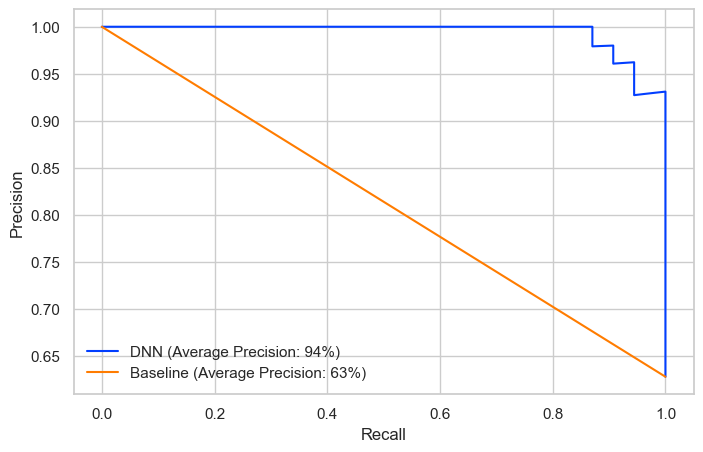

In [26]:
from sklearn.metrics import average_precision_score
pred_p, pred_r, _ = precision_recall_curve(actual, y_conf)
baseline_p, baseline_r, _ = precision_recall_curve(actual, baseline)
pred_ap = average_precision_score(actual, pred)
baseline_ap = average_precision_score(actual, baseline)
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(pred_r, pred_p, label='DNN (Average Precision: %d%%)' % round(pred_ap * 100))
ax.plot(baseline_r, baseline_p, label='Baseline (Average Precision: %d%%)' % round(baseline_ap * 100))
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

### Model complexity

In [27]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Parameters: {total_params}")
    return total_params
    
count_parameters(model)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear0.weight |    600     |
|  linear0.bias  |     20     |
| linear1.weight |    200     |
|  linear1.bias  |     10     |
| linear2.weight |     50     |
|  linear2.bias  |     5      |
| linear3.weight |     5      |
|  linear3.bias  |     1      |
+----------------+------------+
Total Trainable Parameters: 891


891

### LIME Explainer

DNN을 해석하는 한 가지 방법은 입력 계층의 유닛에 연결된 에지의 가중치 또는 강도를 살펴보는 것입니다.  
이는 입력 특징이 출력 예측에 미치는 전반적인 영향을 결정하기 위한 프록시로 볼 수 있습니다.  
그러나 이전 장에서 화이트박스 모델과 트리 앙상블에서 살펴본 것처럼 특징의 중요도를 정확하게 측정할 수 있는 것은 아닙니다.  
주된 이유는 신경망이 숨겨진 레이어에서 입력의 표현을 학습하기 때문입니다.  
초기 입력 특징은 중간 특징과 개념으로 변환됩니다.  
따라서 이러한 입력 특징의 중요성은 입력 계층의 단위와 연결된 에지에 의해서만 결정되는 것이 아닙니다.  

그렇다면 DNN을 어떻게 해석할까요?

DNN을 해석하는 방법에는 여러 가지가 있습니다.  
이전 장에서 배운 모델에 구애받지 않는 방법을 사용할 수 있으며, 그 범위는 전역적입니다.  
모델에 구애받지 않는 기법, 즉 모든 머신 러닝 모델에서 작동할 수 있는 해석 가능성 기법인 PDP와 특징 상호작용 플롯에 대해 배웠습니다.  
또한 모델이 최종 예측에 미치는 전반적인 영향을 살펴본다는 점에서 글로벌 범위의 기법이며, PDP와 특징 상호작용 플롯은 사용하기 쉽고 직관적이며 특정 특징 값이 모델 출력에 어떤 영향을 미치는지 밝혀낼 수 있는 훌륭한 도구입니다.  
또한 데이터 및 모델 편향과 같은 잠재적인 문제를 발견하는 데 어떻게 사용할 수 있는지도 배웠습니다.  
이러한 기법을 유방암 감지를 위해 훈련된 DNN 모델에 매우 쉽게 적용할 수 있습니다.  

그러나 PDP와 특징 상호 작용 플롯이 작동하려면 모델의 입력 특징이 독립적이어야 하는데, 4.2절에서 그렇지 않다는 것을 살펴보았습니다.  
다음 섹션에서는 특히 LIME, SHAP 및 앵커에 중점을 둔 고급 모델 해석 기법에 대해 알아볼 것입니다.  
이러한 해석 가능성 기법은 특정 인스턴스나 예제에 초점을 맞춰 해석하는 국지적 기법입니다.  
이후 장에서는 최종 예측에 대한 각 입력 특징의 기여도를 정량화하는 것을 목표로 하는 특징 귀속 방법에 대해 알아보고, 신경망을 해부하고 중간 숨겨진 레이어와 유닛에서 학습한 특징을 시각화하는 방법도 배우게 될 것입니다.

그림 4.11과 같이 특징 공간을 2차원 공간으로 축소하여 이를 단순화해 보겠습니다.   
이 그림은 모델이 양성 사례와 악성 사례를 구분하는 DNN에 의해 학습된 복잡한 의사 결정 함수를 보여줍니다.  
그림 4.11에서 의사 결정 경계는 의도적으로 과장되어 있는데, 이는 전체적으로 설명하기는 어렵지만 LIME과 같은 기법을 사용하면 국지적으로 설명하기 쉬운 복잡한 함수를 설명하기 위해서입니다.

![Alt text](image-1.png)

LIME은 먼저 해석할 예시를 선택합니다.  
그림 4.12에서는 해석할 악성 사례 하나를 선택했습니다.  
목표는 모델이 선택한 샘플에 대해 어떻게 예측을 내놓는지 해석하기 위해 필요한 만큼 자주 모델을 프로빙하는 것입니다.  
데이터 세트를 교란하여 모델을 프로브하여 새로운 데이터 세트에 대한 모델 예측을 얻을 수 있습니다.

![Alt text](image-2.png)

이 새로운 섭동 데이터 집합은 어떻게 만들까요? 훈련 데이터가 주어지면 각 특징에 대한 핵심 요약 통계를 계산합니다. 숫자 또는 연속형 특징의 경우 평균과 표준 편차를 계산합니다. 범주형 특징의 경우 각 값의 빈도를 계산합니다. 그런 다음 이러한 요약 통계를 기반으로 샘플링하여 새 데이터 세트를 생성합니다. 숫자 피처의 경우 해당 피처에 대한 주제평균과 표준편차가 주어진 가우스 분포에서 데이터를 샘플링합니다. 범주형 특징의 경우, 빈도 분포 또는 확률 질량 함수를 기반으로 샘플링합니다. 이 데이터 집합을 생성한 후에는 그림 4.13과 같이 예측을 구하여 모델을 조사합니다.

선택된 인스턴스는 큰 더하기 기호로 표시됩니다. 교란된 데이터 집합에 대한 악성 및 양성 예측은 각각 작은 더하기 기호와 원으로 표시됩니다.

![Alt text](image-3.png)

교란된 데이터 세트를 생성하고 그에 대한 모델 예측을 얻은 후에는, 선택한 인스턴스와의 근접성에 따라 이러한 새로운 샘플에 가중치를 부여하여 특징 측면에서 유사한 사례를 살펴봄으로써 선택한 인스턴스를 해석합니다.   
해석의 로컬리티는 이 가중치에 의해 포착되며, 따라서 LIME이라는 약어에서 "로컬"은 이 가중치에 의해 포착됩니다.  
그림 4.14는 더 높은 가중치가 주어진 선택된 인스턴스에 가까운 교란된 샘플을 보여줍니다.

![Alt text](image-4.png)

이제 선택한 인스턴스와의 근접성에 따라 샘플에 가중치를 부여하는 방법은 무엇일까요? 원본 논문에서 저자들은 지수 커널 함수를 사용합니다. 지수 커널 함수는 두 개의 매개 변수를 입력으로 받습니다:

- Distance of perturbed sample from picked instance—For the breast cancer dataset (or
tabular data in general), we use Euclidean distance to measure the distance of
the perturbed sample from the picked instance in the feature space. Euclidean
distance is also used for images. For text, the cosine distance measure is used.  

- Kernel width—This is a hyperparameter that can be tuned. If the width is small,
only samples that are close to the picked instance will influence the interpretation.
If the width is large, however, samples that are further away can influence the
interpretation. This is an important hyperparameter, and we will study its impact
on the interpretation in greater depth later. By default, the kernel width is set to
0.75 × √Number of features. So, for the model with 30 input features, the default kernel
width is 4.1. The value of the kernel width can range from zero to infinity.

지수 커널 함수를 사용하면 거리 측면에서 선택한 인스턴스에 가까운 샘플이 멀리 떨어진 샘플보다 더 큰 가중치를 가지게 됩니다. 마지막 단계는 가중치가 적용된 샘플에 대해 쉽게 해석할 수 있는 화이트박스 모델을 맞추는 것입니다. LIME에서는 선형 회귀가 사용되며, 2장에서 살펴본 것처럼 선형 회귀 모델의 가중치를 사용하여 선택한 인스턴스에 대한 중요도 기능을 해석할 수 있습니다(따라서 LIME이라는 약어에서 "해석 가능"이라는 의미). 국지적으로 충실한 해석을 얻을 수 있으며 선형 대리 모델을 피팅하기 때문에 LIME은 DNN 또는 블랙박스 모델에 완전히 무관하므로 LIME이라는 약어에서 "모델 불가지론적"이라고 할 수 있습니다. 그림 4.15는 해석하도록 선택된 인스턴스 근처와 그 주변 영역에 충실한 선형 대리 모델(회색 점선으로 표시)을 보여줍니다. 이제 직접 손을 더럽히고 앞서 훈련한 유방암 진단 DNN 모델에 대해 LIME이 작동하는 것을 확인해 보겠습니다. 먼저 다음과 같이 pip를 사용하여 LIME 라이브러리를 설치합니다:

![Alt text](image-5.png)

### LIME Explainer

In [28]:
import lime
import lime.lime_tabular

![Alt text](image-6.png)

In [29]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [30]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.numpy(), 
                                                   feature_names=data.feature_names, 
                                                   class_names=data.target_names, 
                                                   discretize_continuous=True)

- Because the dataset
is tabular, we use the LimeTabularExplainer class. Other explainer classes are Lime-
ImageExplainer to explain models that use images as inputs and LimeTextExplainer
for text. We will make use of the LimeImageExplainer class in the next chapter when we
deal with images:

이제 해석할 두가지 케이스를 선택하자: benign, malignant  

In [31]:
benign_idx = np.where(y_test.numpy() == 1)[0][0]
malignant_idx = np.where(y_test.numpy() == 0)[0][0]

In [32]:
benign_idx

0

- 첫번째 인덱스를 픽한 것이다.

여기에 표시된 것처럼 교란된 데이터 세트에 대한 DNN 모델의 예측을 제공하기 위해 helper function을 만들어야 합니다:

In [33]:
def prob(data):
    return model.forward(Variable(torch.from_numpy(data)).float()).detach().numpy().reshape(-1, 1)

In [34]:
y_conf

array([5.54280996e-01, 5.54280996e-01, 5.54280996e-01, 5.54280996e-01,
       5.02609432e-01, 4.46966022e-01, 5.54280996e-01, 5.54280996e-01,
       3.42027724e-01, 5.54280996e-01, 5.54280996e-01, 5.54280996e-01,
       4.93022472e-01, 5.54280996e-01, 4.46438305e-02, 4.32504952e-01,
       8.41209069e-02, 5.54280996e-01, 5.15134811e-01, 5.54280996e-01,
       5.54280996e-01, 5.54280996e-01, 9.55968062e-07, 5.27495086e-01,
       5.02688996e-03, 2.89072603e-01, 4.05357545e-03, 5.79613708e-02,
       8.64246977e-05, 5.54280996e-01, 5.54280996e-01, 5.54280996e-01,
       5.87589566e-05, 5.54280996e-01, 5.54280996e-01, 5.54280996e-01,
       3.17797996e-04, 5.54280996e-01, 5.45515537e-01, 5.54280996e-01,
       5.54280996e-01, 5.54280996e-01, 5.54280996e-01, 5.54280996e-01,
       5.54280996e-01, 5.54280996e-01, 1.28673300e-01, 5.54280996e-01,
       5.54280996e-01, 5.54280996e-01, 5.54280996e-01, 5.47943771e-01,
       1.14369981e-01, 5.48508406e-01, 6.82656979e-03, 5.54280996e-01,
      

In [35]:
y_conf[benign_idx]

0.554281

또한 Matplotlib에서 LIME 해석을 플롯하기 위해 다른 함수를 만들어야 합니다. 라이브러리를 사용하여 이 플롯을 만들 수는 있지만 사용자 정의는 허용하지 않습니다. 그래서 제목과 레이블을 추가하고, 색상을 변경하고, LIME 해석을 사용하여 자신만의 플롯을 만들 수 있도록 이 도우미 함수를 만들었습니다:

In [36]:
def lime_exp_as_pyplot(exp, label=0, figsize=(8,5)):
    exp_list = exp.as_list(label=label)
    fig, ax = plt.subplots(figsize=figsize)
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp_list)) + .5
    ax.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    return fig, ax

이제 첫번째 benign case를 해석해보자

Text(0.5, 1.0, 'Benign Case 1 (DNN Confidence: 55%) | Kernel Width = None (Score: 0.15)')

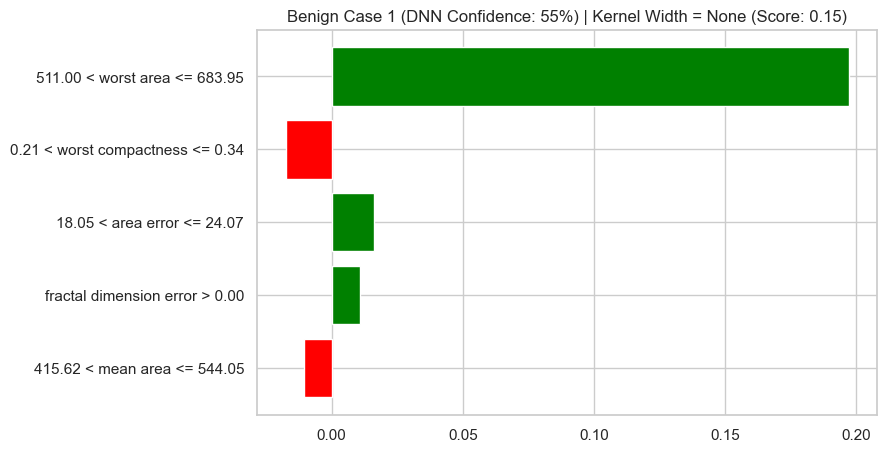

In [37]:
bc1_lime = explainer.explain_instance(X_test.numpy()[benign_idx], 
                                 prob, 
                                 num_features=5, 
                                 top_labels=1)
f, ax = lime_exp_as_pyplot(bc1_lime)
ax.set_title('Benign Case 1 (DNN Confidence: %d%%) | Kernel Width = None (Score: %.2f)' % (round(y_conf[benign_idx] * 100),
                                                                                            bc1_lime.score))

![Alt text](image-7.png)

- 실제 결과와 다름

- 선형 대리 모델의 특징 수를 5개로 제한하고 있으며, LIME은 기본적으로 릿지 회귀 모델을 대리 모델로 사용한다는 점에 유의하세요.   
- 릿지 회귀는 선형 회귀 모델의 변형으로, 정규화를 통해 변수를 선택하거나 매개변수를 제거할 수 있습니다.  
- 높은 정규화 매개변수를 사용하면 예측을 위해 상위 몇 가지 특징만 선택하는 희소 모델을 만들 수 있습니다.  
- 낮은 정규화 파라미터를 사용하면 희소성을 줄일 수 있습니다.  
- 그림 4.16은 양성 사례에 대한 LIME 해석 결과를 보여줍니다.  
- LIME으로 해석하는 데 사용된 양성 사례의 경우 DNN 모델은 0.99의 확률 또는 99%의 신뢰도로 양성이라고 예측했습니다.  
- 이러한 예측에 도달한 방법을 이해하기 위해 그림 4.16은 선형 대리 모델에서 가장 중요한 상위 5가지 특징과 해당 가중치 또는 중요성을 보여줍니다.  
- 가장 중요한 특징은 양수 가중치가 큰 최악의 영역인 것처럼 보입니다. LIME에 따르면, 모델이 양성을 예측한 이유는 최악의 영역 값이 511에서 683.95 사이였기 때문입니다.  
- LIME은 어떻게 이 범위의 값을 얻었나요? 이는 선형 대리 모델에서 사용하는 가중치가 적용된 섭동 데이터 세트의 표준 편차를 기반으로 합니다.

이제 이 해석이 합리적일까요? 이를 검증하려면 4.2절에서 수행한 탐색적 데이터 분석으로 돌아가야 합니다.   
그림 4.3에서 최악의 또는 가장 큰 세포 면적이 700 미만인 경우 악성보다 양성이 훨씬 더 많다는 것을 확인했습니다.  
이제 LIME이 식별한 두 번째로 중요한 특징을 살펴보면, 평균 면적이 415.63에서 544.05 사이인 경우 양성일 가능성이 훨씬 더 높다는 것을 알 수 있습니다.  
이는 그림 4.3에서 관찰한 결과를 통해 더욱 확인됩니다.  
세 번째로 중요한 특징인 평균 둘레에 대해서도 비슷한 관찰을 할 수 있습니다.  
그림 4.16의 제목에서 커널 너비와 점수를 보셨을 텐데요, 이에 대해서는 잠시 후에 설명하겠습니다.

이제 LIME을 사용하여 해석할 테스트 세트의 첫 번째 악성 사례를 살펴보겠습니다.  
이전과 동일한 코드를 사용할 수 있지만 malignant_idx를 사용하여 테스트 세트에서 올바른 특징값을 선택해야 한다는 것을 기억해야 합니다.  
연습 삼아 직접 해보시기 바랍니다. 결과적인 LIME 해석은 그림 4.17에 나와 있습니다.  
가장 중요한 두 번째 특징은 양성의 경우와 동일하지만 값의 범위가 다르며, 또한 가장 중요한 특징(최악의 셀 영역)에 대한 가중치도 음수입니다.  
이는 해당 특징이 모델의 출력에 부정적인 영향을 미칠 것으로 예상하기 때문에 의미가 있습니다.  
DNN은 양성 클래스(이 경우 양성)의 확률을 예측하도록 학습됩니다.  
따라서 사례가 악성인 경우 모델의 출력은 가능한 한 낮을 것으로 예상합니다.  
즉, 사례가 양성일 확률은 가능한 한 낮아야 합니다.

Text(0.5, 1.0, 'Malignant Case 1 (DNN Confidence: 96%) | Kernel Width = None (Score: 0.01)')

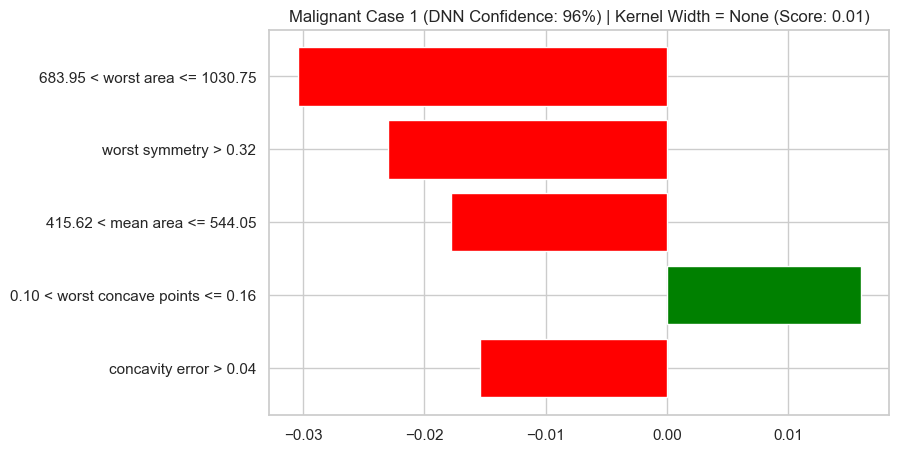

In [38]:
exp = explainer.explain_instance(X_test.numpy()[malignant_idx], 
                                 prob, 
                                 num_features=5, 
                                 top_labels=1)
f, ax = lime_exp_as_pyplot(exp)
ax.set_title('Malignant Case 1 (DNN Confidence: %d%%) | Kernel Width = None (Score: %.2f)' % (100 - round(y_conf[malignant_idx] * 100),
                                                                                               exp.score))

![Alt text](image-8.png)

- 이 것도 결과가 다름

- 이 악성 사례의 경우 DNN은 이 사례가 0의 확률로 양성이라고 예측합니다. 즉, 모델은 이 케이스가 악성이라고 100% 확신합니다. 
- 이제 특징값 범위를 살펴봅시다. 최악의, 즉 가장 큰 세포 면적이 683.95보다 크지만 1030.75보다 작기 때문에 모델이 악성을 예측했음을 알 수 있습니다.  
- 이는 탐색적 분석에서 해당 범위에서 양성 사례보다 악성 사례가 더 많이 관찰되었기 때문에 의미가 있습니다(그림 4.3 참조). 다른 특징에 대해서도 비슷한 관찰을 할 수 있습니다.

IMPACT OF THE KERNEL WIDTH

- 커널폭은 LIME의 중요한 하이퍼파라미터라는 점을 지적하는 것이 중요합니다.  
- 올바른 커널 폭을 선택하는 것은 중요하며 해석의 품질에 영향을 미칩니다.  
- 해석하고자 하는 모든 인스턴스에 대해 동일한 커널 폭을 선택할 수는 없으며, 폭의 선택은 LIME이 선형 대리 모델에 대해 고려하는 가중치가 부여된 섭동 샘플에 영향을 미칩니다.  
- 커널 폭을 크게 선택하면, 선택한 인스턴스에서 멀리 떨어진 샘플이 선형 대리 모델에 영향을 미칩니다.  
- 이는 서로게이트 모델이 가능한 한 원래의 블랙박스 모델에 국지적으로 충실하기를 원하기 때문에 바람직하지 않을 수 있습니다. 기본적으로 LIME 라이브러리는 기능 수의 제곱근에 0.75의 계수를 곱한 커널 너비를 사용합니다.  
- 따라서 커널 너비가 None인 경우 기본값이 사용됩니다.  
- LIME을 사용하여 해석해야 하는 모든 인스턴스에 동일한 커널 너비가 적용되지 않을 수도 있습니다.  
- 해석의 품질을 평가하기 위해 LIME은 설명, 즉 충실도 점수를 제공합니다.  
- 이 매개 변수는 결과 LIME 설명에 대한 점수라고 불리며, 점수가 높을수록 LIME에서 사용하는 선형 모델이 블랙박스 모델에 대한 근사치임을 의미합니다.  
- 커널 폭과 LIME 충실도 점수는 그림 4.16과 4.17의 제목에 나와 있습니다.

이제 다른 benign 케이스를 통해 커널 폭에 대한 영향을 알아보자.  
두번째 샘플을 보자

Text(0.5, 1.0, 'Benign Case 2 (DNN Confidence: 55%) | Kernel Width = None (Score: 0.20)')

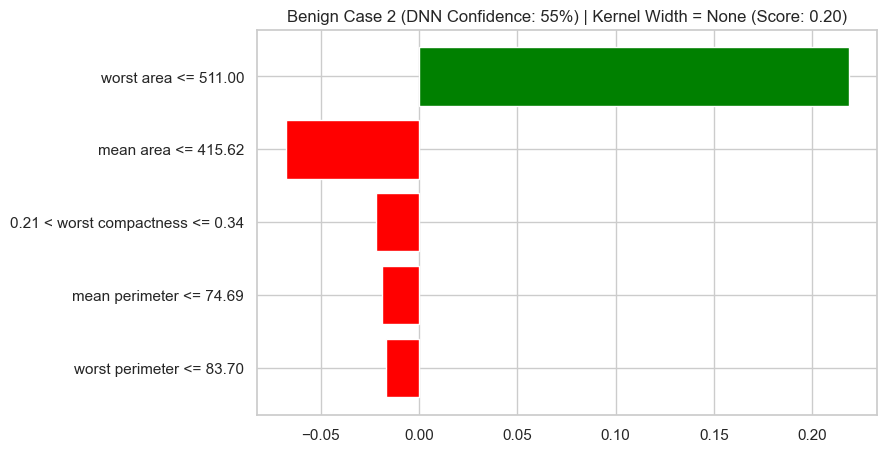

In [39]:
benign_idx2 = np.where(y_test.numpy() == 1)[0][1]
exp = explainer.explain_instance(X_test.numpy()[benign_idx2], 
                                 prob, 
                                 num_features=5, 
                                 top_labels=1)
f, ax = lime_exp_as_pyplot(exp)
ax.set_title('Benign Case 2 (DNN Confidence: %d%%) | Kernel Width = None (Score: %.2f)' % (round(y_conf[benign_idx2] * 100),
                                                                                            exp.score))

- 앞서 만든 LIME 설명자에서는 기본값인 0.75 ×sqrt(특징 수)를 사용했습니다. 데이터 세트의 특징 수가 30개이므로 커널 너비가 4로 평가됩니다. 또한 해석에 미치는 영향을 확인하기 위해 더 작은 커널 너비 1로 초기화되는 또 다른 LIME 설명자를 만들어 보겠습니다. 다음 코드는 커널 너비가 1인 LIME 설명자를 생성하는 방법을 보여줍니다:

Text(0.5, 1.0, 'DNN Confidence that Case is Benign: 55%')

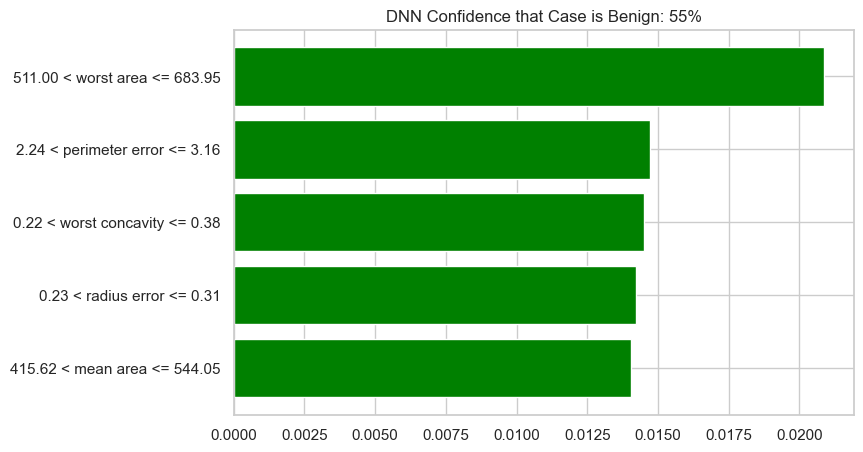

In [40]:
explainer_kw1 = lime.lime_tabular.LimeTabularExplainer(X_train.numpy(), 
                                                       feature_names=data.feature_names, 
                                                       class_names=data.target_names,
                                                       kernel_width=1,
                                                       discretize_continuous=True)
exp = explainer_kw1.explain_instance(X_test.numpy()[benign_idx], 
                                     prob, 
                                     num_features=5, 
                                     top_labels=1)
f, ax = lime_exp_as_pyplot(exp)
ax.set_title('DNN Confidence that Case is Benign: %d%%' % (round(y_conf[benign_idx] * 100)))

.... 생략

### SHAP

- SHAP은 SHapley Additive exPlanations의 약자로, 2017년에 ScottM이 제안했습니다.  
- 이는 LIME(및 선형 대리모형)과 게임 이론의 아이디어를 통합한 것으로, 설명의 정확성에 대해 LIME보다 더 수학적 보증을 제공합니다.  
- 샤플리 값은 협동 게임에서 플레이어 연합의 영향을 정량화하는 게임 이론의 개념입니다.  
- 이제 협동 게임, 게임의 플레이어, 플레이어 연합이 무엇을 의미하는지 살펴보겠습니다. 모델 해석 가능성의 맥락에서 협동 게임은 모델과 그 모델이 내놓는 예측입니다.  
- 모델에 입력되는 특징은 플레이어에 해당하며, 플레이어의 연합은 최종 예측을 도출하기 위해 서로 상호 작용하는 특징의 집합입니다.  
- 따라서 샤플리 값은 모델 예측(즉, 협동 게임)에 대한 특징(즉, 플레이어)과 이들의 상호작용(즉, 플레이어 연합)의 영향을 정량화하는 데 사용될 수 있습니다. 그림 4.20에 표시된 구체적인 예시를 통해 SHAP 해석 가능성 기법을 자세히 살펴봅시다.

SHAP의 기본 개념은 LIME의 기본 개념과 매우 유사합니다.   
- 첫 번째 단계는 설명할 인스턴스를 선택하는 것입니다.  
- 그림 4.20에서 선택된 인스턴스는 첫 번째 윈 인덱스 0으로 표시되어 있습니다.  
- SHAP은 게임 이론적 개념을 사용하기 때문에 선택된 인스턴스는 모든 특징의 연합으로 구성됩니다.  
- 모든 특징이 선택되거나 "켜지면" 데이터 집합의 모든 특징에 대해 모두 1을 포함하는 벡터로 표시됩니다.  
- 그림 4.20의 첫 번째 열은 연합 벡터를 테이블로 보여줍니다.  
- 선택된 인스턴스의 경우 연합 벡터는 모두 1로 구성되므로 이 벡터를 특징 공간으로 변환할 때 해당 인스턴스에 대한 모든 실제 특징 값을 선택합니다.  
- 이 특징 벡터는 그림 4.20의 두 번째 열에 표로 표시되어 있습니다.

![Alt text](image-9.png)

해석할 인스턴스를 선택했으면 다음 단계는 섭동 데이터셋을 생성하는 것입니다.   
- 이 과정은 LIME과 동일하지만, LIME과 달리 SHAP에서는 특징이 무작위로 "켜짐" 또는 "꺼짐"인 여러 개의 연합 벡터를 생성하는 것입니다.  
- 기능이 켜져 있으면 연합 벡터의 값은 1이 되고, 기능이 꺼져 있으면 연합 벡터의 값은 0이 됩니다.  
- 우리는 기능이 켜져 있을 때 기능 공간에서 기능을 표현하는 방법을 알고 있으며, 해석하기 위해 선택한 인스턴스에서 실제 값을 선택하기만 하면 됩니다.   
- 그러나 기능이 꺼져 있으면 해당 기능에 대한 훈련 세트에서 무작위로 값을 선택합니다.

왜곡된 데이터 집합을 생성한 후, 다음 단계는 선택한 인스턴스와의 근접성에 따라 데이터 집합에 가중치를 부여하는 것입니다.   
- 이 과정도 LIME과 유사하지만, LIME과 달리 SHAP은 지수 커널 함수가 아닌 SHAP 커널을 사용해 외란 데이터 세트의 샘플에 대한 가중치를 결정합니다.  
- SHAP 커널 함수는 매우 낮거나 매우 높은 수의 오프피처로 구성된 연합에 더 높은 가중치를 부여합니다.  
- 다음 단계는 가중치가 부여된 데이터 세트에 선형 모델을 맞추고 선택한 인스턴스에 대한 해석으로 선형 모델의 계수 또는 가중치를 반환하는 것으로, LIME과 동일합니다.  
- 이러한 계수 또는 가중치를 샤플리 값이라고 합니다.  
- 이제 앞서 학습한 유방암 진단 모델에서 SHAP이 실제로 작동하는 것을 보겠습니다. SHAP의 작성자는 GitHub에서 Python 라이브러리를 만들었습니다. 이 라이브러리는 다음과 같이 pip를 사용하여 설치할 수 있습니다:

![Alt text](image-10.png)

In [41]:
import shap
shap.initjs()

In [42]:
shap_explainer = shap.KernelExplainer(prob, 
                                      X_train.numpy(), 
                                      link="logit")
shap_values = shap_explainer.shap_values(X_test.numpy(), nsamples=100)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/86 [00:00<?, ?it/s]

- 선형 대리 모델에는 포지티브 클래스에 대한 확률 추정치를 출력하는 이진 분류기를 다루기 때문에 로짓 링크 함수가 사용된다는 점에 유의하세요. 회귀 문제의 경우 링크 매개 변수를 ID로 전환할 수 있습니다.   
- 다음으로 다음과 같이 테스트 집합의 모든 데이터에 대한 SHAP 값을 구했습니다.

You can now obtain the SHAP interpretation for the first benign case as a Matplotlib
plot as shown here:

In [43]:
benign_idx = np.where(y_test.numpy() == 1)[0][0]
malignant_idx = np.where(y_test.numpy() == 0)[0][0]
benign_idx2 = np.where(y_test.numpy() == 1)[0][1]
malignant_idx2 = np.where(y_test.numpy() == 0)[0][1]

In [44]:
df_test = pd.DataFrame(X_test.numpy(), columns=data['feature_names'])
df_test

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0.02950,0.1761,0.06540,...,14.42,21.95,99.21,634.3,0.1288,0.32530,0.34390,0.09858,0.3596,0.09166
1,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,...,11.88,22.94,78.28,424.8,0.1213,0.25150,0.19160,0.07926,0.2940,0.07587
2,11.06,17.12,71.25,366.5,0.11940,0.10710,0.04063,0.04268,0.1954,0.07976,...,11.69,20.74,76.08,411.1,0.1662,0.20310,0.12560,0.09514,0.2780,0.11680
3,11.15,13.08,70.87,381.9,0.09754,0.05113,0.01982,0.01786,0.1830,0.06105,...,11.99,16.30,76.25,440.8,0.1341,0.08971,0.07116,0.05506,0.2859,0.06772
4,14.04,15.98,89.78,611.2,0.08458,0.05895,0.03534,0.02944,0.1714,0.05898,...,15.66,21.58,101.20,750.0,0.1195,0.12520,0.11170,0.07453,0.2725,0.07234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,20.47,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,0.05419,...,23.23,27.15,152.00,1645.0,0.1097,0.25340,0.30920,0.16130,0.3220,0.06386
82,13.37,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823,...,14.26,22.75,91.99,632.1,0.1025,0.25310,0.33080,0.08978,0.2048,0.07628
83,11.67,20.02,75.21,416.2,0.10160,0.09453,0.04200,0.02157,0.1859,0.06461,...,13.35,28.81,87.00,550.6,0.1550,0.29640,0.27580,0.08120,0.3206,0.08950
84,20.18,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,0.2906,0.08142,...,23.37,31.72,170.30,1623.0,0.1639,0.61640,0.76810,0.25080,0.5440,0.09964


In [45]:
# Plot the SHAP values for the Benign case
plot = shap.force_plot(shap_explainer.expected_value[0], 
                       shap_values[0][benign_idx,:], 
                       X_test.numpy()[benign_idx,:],
                       feature_names=data['feature_names'],
                       link="logit")
plot

![Alt text](image-12.png)

- 결과가 다름

- 결과 플롯은 그림 4.21에 나와 있습니다.  
- 첫 번째 양성 사례의 경우, DNN 모델은 0.99의 확률 또는 99%의 신뢰도로 양성이라고 예측했습니다.  
- SHAP 라이브러리는 각 특징 값이 어떻게 기본 예측을 위 또는 아래로 밀어내는지 확인할 수 있는 훨씬 더 멋진 시각화를 제공합니다.  
- 그림 4.21에서 약 0.63의 기본 값을 볼 수 있습니다. 이것은 양성 사례의 비율을 나타내는 양성 클래스 비율입니다.  
- 4.2절에서 데이터를 탐색했을 때, 데이터 세트에서 약 63%의 사례가 양성이라는 것을 관찰했습니다.  
- SHAP 시각화의 이면에는 특징 값이 기준 예측 확률을 0.63에서 0.99로 어떻게 밀어 올리는지 확인하는 것이 있습니다.  
- 피처의 영향은 막대의 길이로 표시됩니다.  
- 그림에서 최악의 셀 영역과 평균 셀 영역 피처의 샤플리 값이 가장 커서 기준 예측을 가장 많이 밀어붙이는 것을 볼 수 있습니다. 다음으로 중요한 피처는 최악의 셀 둘레입니다.

In [46]:
# Plot the SHAP values for the Benign case
plot = shap.force_plot(shap_explainer.expected_value[0], 
                        shap_values[0][benign_idx2,:], 
                        X_test.numpy()[benign_idx2,:],
                        feature_names=data['feature_names'],
                        link="logit")
plot


... 생략